In [66]:
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity



import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns',185)
pd.set_option('display.max_rows',185)

In [3]:
df = pd.read_csv("PBL 5 recommendation data.csv",encoding='latin-1')

In [4]:
df.head(10)

,Customers.id,Customers.fname,Customers.lname,Customers.company,Customers.create_date,Customers.status,Customers.mailing,Customers.reminders,Customers.tax_exempt,Customers.account_id,Customers.sales_rep,Customers.rewards,Customers.profile_id,Customers.last_modified,Customers.customer_type,Orders.id,Orders.customer_id,Orders.fname,Orders.lname,Orders.company,Orders.order_number,Orders.reorder_id,Orders.external_source,Orders.external_id,Orders.currency,Orders.sales_rep,Orders.subtotal,Orders.tax,Orders.shipping,Orders.coupon_id,Orders.coupon_amount,Orders.gift_id,Orders.gift_amount,Orders.fee_name,Orders.fee_amount,Orders.discount_name,Orders.discount_amount,Orders.total,Orders.balance_due,Orders.shipping_carrier,Orders.shipping_method,Orders.shipping_trans,Orders.shipping_flags,Orders.weight,Orders.tracking,Orders.payment_status,Orders.payment_date,Orders.payment_user,Orders.payment_type,Orders.payment_method,Orders.payment_amount,Orders.purchase_order,Orders.payment_id,Orders.payment_code,Orders.payment_ref,Orders.status,Orders.placed_date,Orders.updated_date,Orders.shipped_date,Orders.comments,Orders.notes,Orders.registry_id,Orders.gift_message,Orders.website,Orders.mailing,Orders.flags,Orders.partial_ship,Orders.customer_type,Order_Items.id,Order_Items.parent,Order_Items.product_id,Order_Items.product_name,Order_Items.attributes,Order_Items.attribute_names,Order_Items.attribute_prices,Order_Items.qty,Order_Items.price,Order_Items.cost,Order_Items.registry_item,Order_Items.related_id,Order_Items.reorder_frequency,Order_Items.account_id,Order_Items.flags,Products.id,Products.status,Products.product_type,Products.template,Products.vendor,Products.import_id,Products.name,Products.display_name,Products.menu_name,Products.list_price,Products.price,Products.sale_price,Products.cost,Products.flags,Products.left_flag,Products.right_flag,Products.last_modified,Products.taxable,Products.shopping_gtin,Products.shopping_brand,Products.shopping_mpn,Products.shopping_gender,Products.shopping_color,Products.shopping_age,Products.shopping_flags,Products.amazon_asin,Products.amazon_type,Products.amazon_item_type,Products.amazon_price,Products.google_shopping_id,Products.google_shopping_type,Products.google_shopping_cat,Products.google_adwords,Products.shopping_cat,Products.shopping_type,Products.pricegrabber_cat,Products.shopzilla_cat,Products.thefind_cat,Products.quickbooks_id,Products.qb_edit_sequence,Products.price_break_type,Products.price_breaks,Products.short_description,Products.long_description,Products.websites,Products.video,Products.audio,Products.seo_title,Products.seo_description,Products.seo_keywords,Products.seo_header,Products.seo_footer,Products.seo_url,Products.seo_category,Products.unit,Products.packaging,Products.display_packaging,Products.multiple,Products.length,Products.width,Products.height,Products.rx,Products.latex,Products.upc,Products.msds_link,Products.msds_label,Products.lit_link,Products.lit_label,Products.hcpcs,Products.case_qty,Products.markup,Products.override_markup,Products.notes,Products.import_flags,Products.map_price,Products.features_title,Products.warranty,Products.hygienic,Products.default_quantity,Products.user_size,Products.assembly,Products.installation,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.shipping_weight,Products.handling_time,Products.rotation_link,Products.google_shopping_label,Products.product_option,Products.size,Products.material,Products.arm_style,Products.leg_style,Products.seat_size,Products.family_id,Products.saved_status,Products.freight_cost
0,797,Christy,Dill,Company0,1426018724,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1437764306,0.0,3758,797,Christy,Dill,Company0,3758,NaN,NaN,NaN,USD,NaN,57.20,0.0,9.95,13.0,2.86,NaN,NaN,NaN,NaN,NaN,NaN,64.29,NaN,fedex,11|Ground,NaN,NaN,NaN,5.7204E+14,3.0,1.426019e+09,NaN,authorize.net,NaN,64.29,NaN,6993607863,510142,NaN,1,1426019099,1.438868e+09,1.426101e+09,NaN,Insured By Eye4Fraud,NaN,NaN,NaN,NaN,NaN,NaN,0.0,528

In [5]:
df.shape

(4194, 181)

# Eksik veri analizi

In [6]:
# %50'den fazla eksik veri içeren sütunları çıkarma
temiz_df = df.loc[:,df.isnull().mean()<0.5]
temiz_df.shape, temiz_df.columns

((4194, 85),
 Index(['Customers.id', 'Customers.fname', 'Customers.lname',
        'Customers.create_date', 'Customers.mailing', 'Customers.last_modified',
        'Customers.customer_type', 'Orders.id', 'Orders.customer_id',
        'Orders.fname', 'Orders.lname', 'Orders.order_number',
        'Orders.currency', 'Orders.subtotal', 'Orders.tax', 'Orders.shipping',
        'Orders.total', 'Orders.shipping_carrier', 'Orders.shipping_method',
        'Orders.tracking', 'Orders.payment_status', 'Orders.payment_date',
        'Orders.payment_type', 'Orders.payment_amount', 'Orders.payment_id',
        'Orders.payment_code', 'Orders.status', 'Orders.placed_date',
        'Orders.updated_date', 'Orders.shipped_date', 'Orders.customer_type',
        'Order_Items.id', 'Order_Items.parent', 'Order_Items.product_id',
        'Order_Items.product_name', 'Order_Items.qty', 'Order_Items.price',
        'Order_Items.cost', 'Products.id', 'Products.status',
        'Products.template', 'Products.vend

In [7]:
temiz_df.head()

,Customers.id,Customers.fname,Customers.lname,Customers.create_date,Customers.mailing,Customers.last_modified,Customers.customer_type,Orders.id,Orders.customer_id,Orders.fname,Orders.lname,Orders.order_number,Orders.currency,Orders.subtotal,Orders.tax,Orders.shipping,Orders.total,Orders.shipping_carrier,Orders.shipping_method,Orders.tracking,Orders.payment_status,Orders.payment_date,Orders.payment_type,Orders.payment_amount,Orders.payment_id,Orders.payment_code,Orders.status,Orders.placed_date,Orders.updated_date,Orders.shipped_date,Orders.customer_type,Order_Items.id,Order_Items.parent,Order_Items.product_id,Order_Items.product_name,Order_Items.qty,Order_Items.price,Order_Items.cost,Products.id,Products.status,Products.template,Products.vendor,Products.import_id,Products.name,Products.display_name,Products.list_price,Products.price,Products.cost,Products.flags,Products.last_modified,Products.taxable,Products.shopping_gtin,Products.shopping_brand,Products.shopping_mpn,Products.shopping_flags,Products.amazon_asin,Products.amazon_item_type,Products.google_shopping_id,Products.google_shopping_type,Products.google_shopping_cat,Products.shopping_cat,Products.shopping_type,Products.pricegrabber_cat,Products.shopzilla_cat,Products.thefind_cat,Products.quickbooks_id,Products.qb_edit_sequence,Products.short_description,Products.long_description,Products.seo_title,Products.seo_url,Products.seo_category,Products.unit,Products.packaging,Products.multiple,Products.upc,Products.hcpcs,Products.case_qty,Products.override_markup,Products.import_flags,Products.shipping_length,Products.shipping_width,Products.shipping_height,Products.family_id,Products.saved_status
0,797,Christy,Dill,1426018724,NaN,1437764306,0.0,3758,797,Christy,Dill,3758,USD,57.20,0.0,9.95,64.29,fedex,11|Ground,5.7204E+14,3.0,1.426019e+09,authorize.net,64.29,6993607863,510142,1,1426019099,1.438868e+09,1.426101e+09,0.0,5284,3758,2310.0,"Basic Rollators, Green",1,57.20,44.00,2310.0,0.0,sub-product-detail.html,1.0,3.0,"Basic Steel Rollators,Green","Basic Lightweight Rollators For Adults, With S...",80.70,57.64,44.00,0.0,1.463163e+09,1.0,1.088440e+13,MEDLINE,MDS86850EGS,62.0,B00I6GQE0A,health-care-products,generic/online%3Aen%3AUS%3A2310,"Walking Aids > Rollators, & Walkers > Rollators",Health & Beauty > Health Care,NaN,NaN,NaN,NaN,NaN,8000064C-1434298761,1.450325e+09,"ROLLATOR,BASIC,STEEL,6"",GREEN","<ul><li> Classically designed, value priced</...","Basic Lightweight Rollators For Adults, With S...",Basic-Rollators-For-Adults-With-Seat-Green-6-W...,0.0,EA,1 Each / Each,1 EA,NaN,E0149 +E0156,1.0,0.0,136.0,24.80,7.50,30.40,PF61071,0.0
1,3,John,Smith,1386089139,NaN,1437764354,0.0,23,3,John,Smith,23,USD,20.00,NaN,9.99,29.99,fedex,11|Ground,1.28597E+14,3.0,1.386090e+09,authorize.net,29.99,0,0,1,1386090455,1.440529e+09,1.386103e+09,0.0,31,23,177.0,"Urinary Drain Bags,0.000",4,5.00,1.87,177.0,1.0,sub-product-detail.html,1.0,3.0,Urinary Drain Bags,Urinary Drain Bags,14.41,10.29,1.87,65.0,1.462370e+09,1.0,1.008020e+13,MEDLINE,DYNC1674H,62.0,B000QF7Y76,health-care-products,NaN,"Incontinence, Urology & Ostomy > Urology > Dra...",Health & Beauty > Health Care,199.0,Miscellaneous,Health & Beauty > Medical Supplies > Medical Aids,22005.0,Health & Beauty > Medical Supplies > Medical Aids,80008C35-1438901283,1.450322e+09,"BAG,DRAINAGE,UROLOGY,2000ML,ANTI REFLUX",<ul><li> Only Medline drain bags have a slide...,Urinary Drain Bags | MEDLINE - DYNC1674H,Urinary-Drain-Bags0000,0.0,EA,1 Each / Each,1 EA,NaN,A4357,1.0,0.0,0.0,8.00,7.00,1.50,PF02132,NaN
2,3,John,Smith,1386089139,NaN,1437764354,0.0,9531,3,John,Smith,9531,USD,68.78,0.0,9.95,78.73,manual,0|Standard Shipping,NaN,3.0,1.449604e+09,authorize.net,78.73,0,0,3,1449603652,1.450213e+09,NaN,0.0,11655,9531,1.0,"SensiCare Nitrile Exam Gloves, Blue, XX-Large",1,68.78,52.50,1.0,0.0,sub-product-detail.html,1.0,3.0,"SensiCare Nitrile Exam Gloves,Blue,XX-Large","SensiCare Nitrile Exam Gloves, Blue, XX-Large",96.29,68.78,52.50,32896.0,1.463163e+09,1.0,4.0

# Satış Miktarına Göre En Popüler Ürünler

In [8]:
# Ürün ismine göre guruplandırıp müşterinin kaç adet aldıklarını topladık ve en çok satılandan en az satılana göre sıraladık
populer_urunler_hacim = temiz_df.groupby('Order_Items.product_name')['Order_Items.qty'].sum().sort_values(ascending=False).head(10)

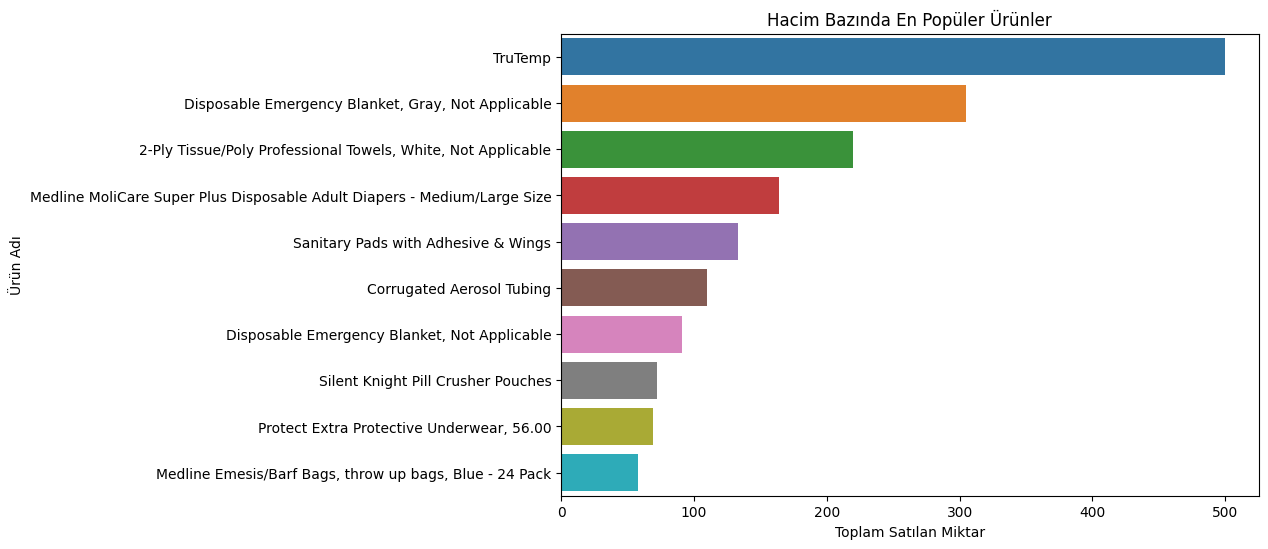

In [9]:
plt.figure(figsize=(9, 6))
sns.barplot(x=populer_urunler_hacim.values, y=populer_urunler_hacim.index)
plt.title('Hacim Bazında En Popüler Ürünler')
plt.xlabel('Toplam Satılan Miktar')
plt.ylabel('Ürün Adı')
plt.show()

### En çok satılan ürün: Termometre

# Dolar Cinsinden En Popüler Ürünler

In [10]:
temiz_df['Toplam_Satis_Tutari'] = temiz_df['Order_Items.qty'] * temiz_df['Order_Items.price']
populer_urunler_dolar = temiz_df.groupby('Order_Items.product_name')['Toplam_Satis_Tutari'].sum().sort_values(ascending=False).head(10)
populer_urunler_dolar.head(3)

Order_Items.product_name
Disposable Emergency Blanket, Gray, Not Applicable                                                                                    10556.05
Medline MoliCare Super Plus Disposable Adult Diapers - Medium/Large Size                                                               8984.40
Medline Deluxe Aluminum Transport Chair With Hand Brakes, Red, Wheels Front 8" Back 12", Leightweight Weighs 23 Lbs, Cap. 300 Lbs.     5940.54
Name: Toplam_Satis_Tutari, dtype: float64

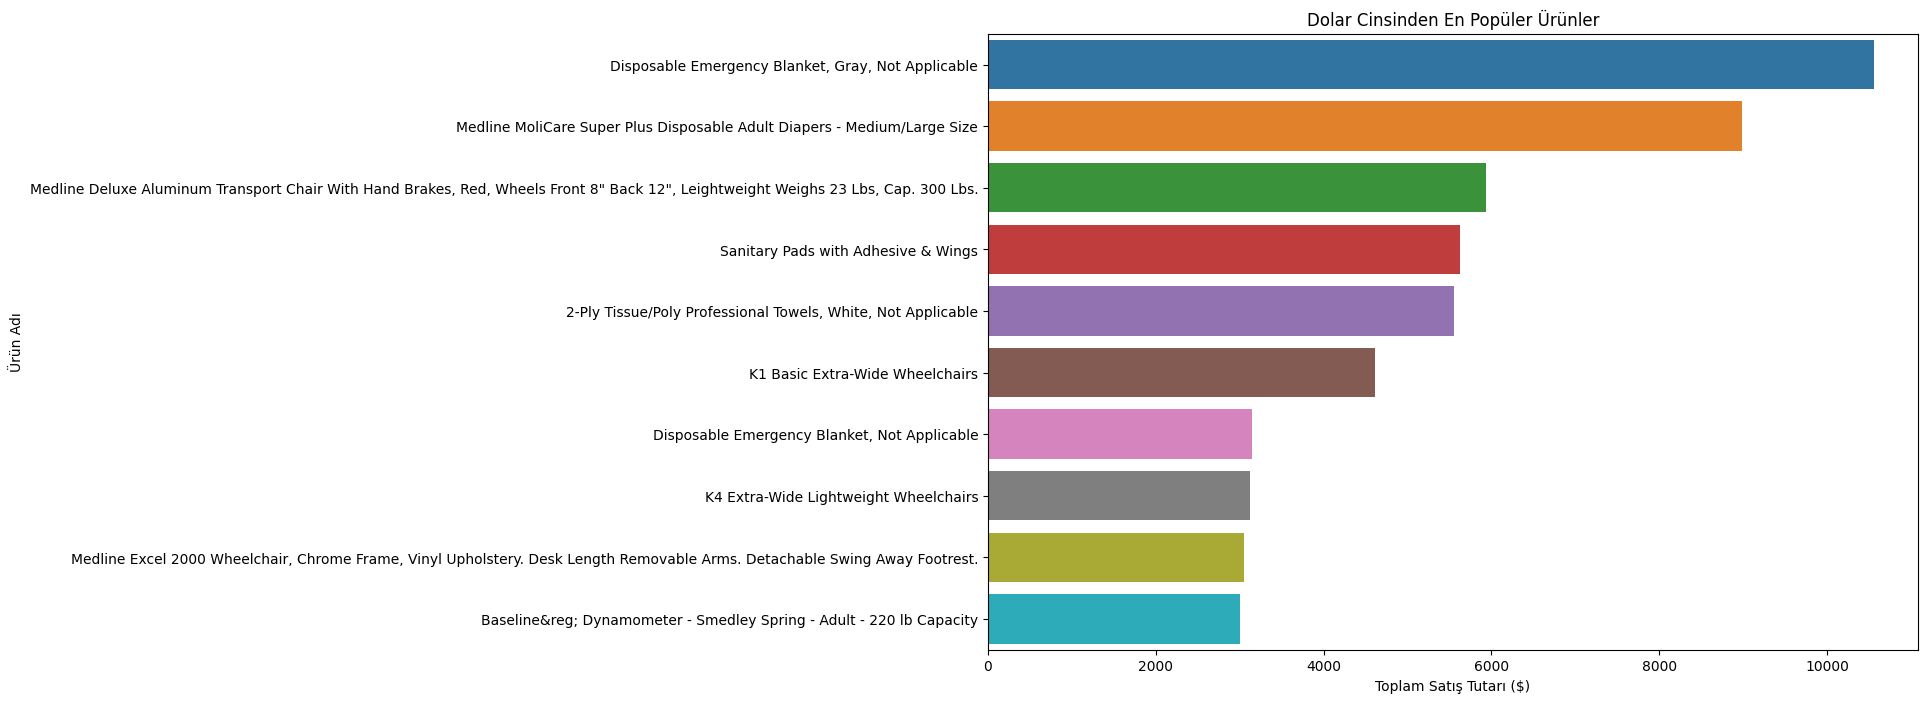

In [11]:
plt.figure(figsize=(12, 8))
sns.barplot(x=populer_urunler_dolar.values, y=populer_urunler_dolar.index)
plt.title('Dolar Cinsinden En Popüler Ürünler')
plt.xlabel('Toplam Satış Tutarı ($)')
plt.ylabel('Ürün Adı')
plt.show()

### En yüksek fiyat bazlı satılan ürün: Acil durum battaniyesi

# En Çok Satış Yapan Şirket

In [12]:
# 'Order_Items.qty' ve 'Order_Items.price' sütunlarını kullanarak 'Total_Sales' sütununu hesaplama
df['Total_Sales'] = df['Order_Items.qty'] * df['Order_Items.price']

# En fazla satış tutarına ulaşan şirketi bulmak için, şirket isimlerine göre gruplandırma yapıp 
# toplam satış tutarlarını hesaplıyoruz ve en yüksek toplam satış tutarına sahip olan şirketin ismini alıyoruz.
en_fazla_satin_alan_sirket = df.groupby('Orders.company')['Total_Sales'].sum().nlargest(10)
en_fazla_satin_alan_sirket.head()

Orders.company
Company59     13186.41
Company343     5628.56
Company281     3061.96
Company145     2696.38
Company207     2375.59
Name: Total_Sales, dtype: float64

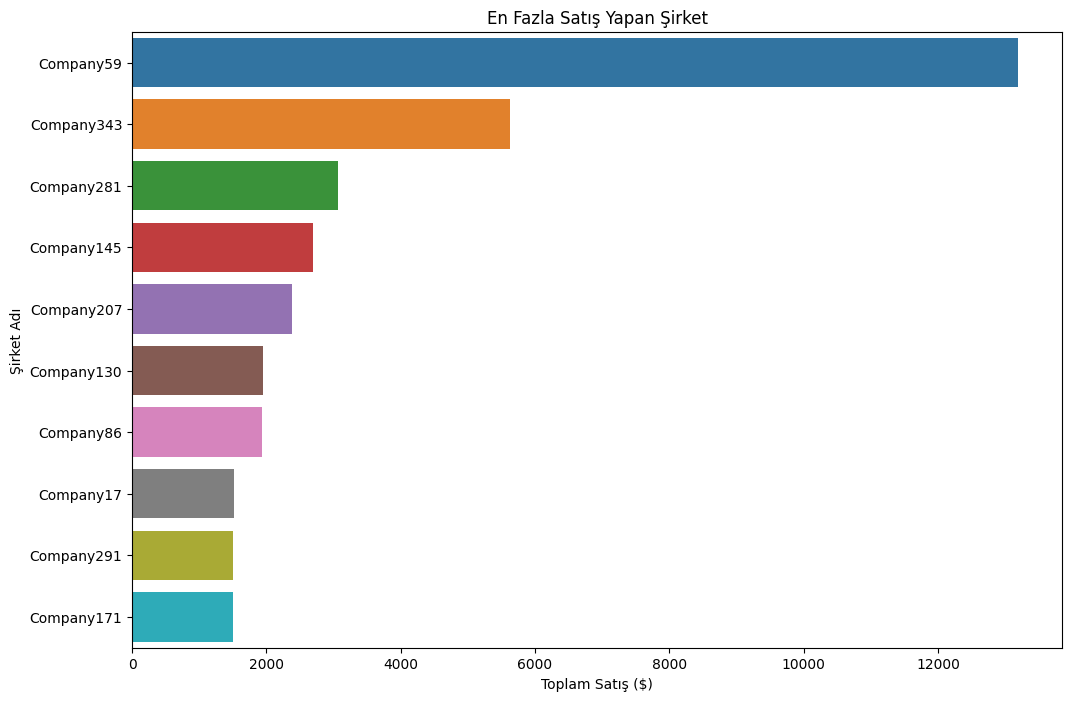

In [13]:
plt.figure(figsize=(12, 8))
sns.barplot(x=en_fazla_satin_alan_sirket.values, y=en_fazla_satin_alan_sirket.index)
plt.title('En Fazla Satış Yapan Şirket')
plt.xlabel('Toplam Satış ($)')
plt.ylabel('Şirket Adı')
plt.show()

# Popülerlik Temelli Öneri Sistemi

In [18]:
populer_urunler_hacim = temiz_df.groupby('Order_Items.product_name')['Order_Items.qty'].sum().sort_values(ascending=False).head(15)
# Order_Items.product_name stününa göre gurupladık ve Order_Items.qty değerlerini toplayıp büyükten küçüğe sıraladık

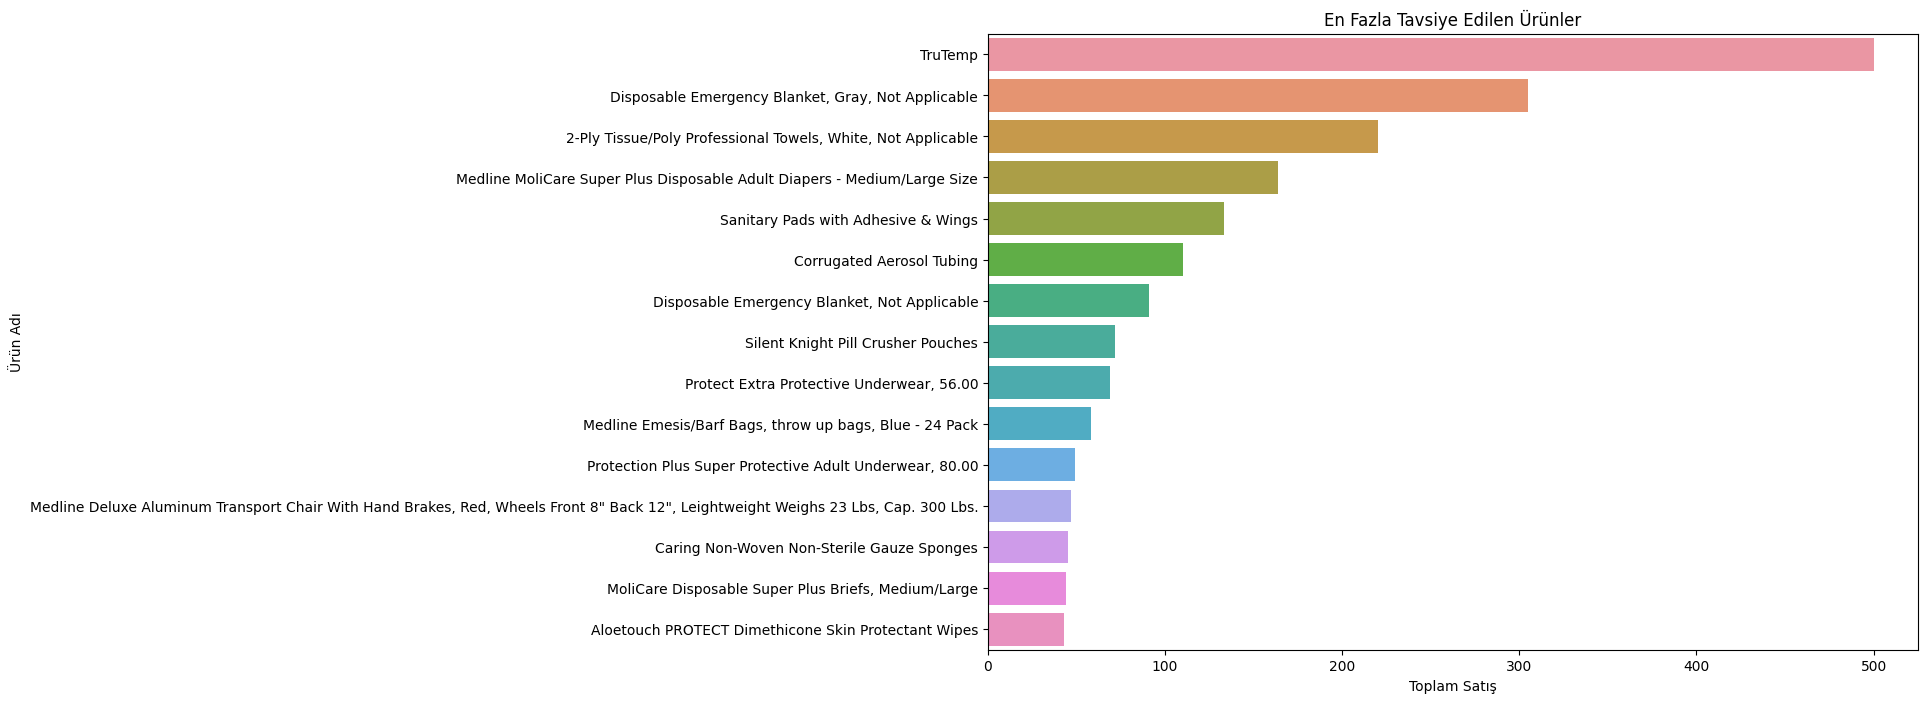

In [21]:
plt.figure(figsize=(12, 8))
sns.barplot(x=populer_urunler_hacim.values, y=populer_urunler_hacim.index)
plt.title('En Fazla Tavsiye Edilen Ürünler')
plt.xlabel('Toplam Satış')
plt.ylabel('Ürün Adı')
plt.show()

# Matris çarpanlarına ayırmayı kullanarak bir öneri sistemi oluşturulması

In [55]:
matrix_degerler = df.pivot_table(index='Products.id', columns='Products.name',values='Orders.total', fill_value=0)
matrix_degerler.head()

Products.name,1 Box Of Medline Commode Liners with Absorbent Pad,"1-Ply Blockade AngelStat Surgical Gowns,Ceil Blue,Extra Large","1/2"" self-adhesive hook material, 25 yard dispenser box, white","1/2"" self-adhesive loop material, 25 yard dispenser box, white","100% Cotton Unisex Reversible Hyperbaric Scrub Tops,Misty Green,MZS","100% Cotton Unisex Reversible Tops,Ceil Blue,MHS","18"" Hamper Stands,Standard","2"" self-adhesive loop material, 10 yard dispenser box, tan","2"" self-adhesive loop material, 25 yard dispenser box, tan","2-Ply Tissue/Poly Professional Towels,Not Applicable",2000 Wheelchairs,"24 Hour Urine Collection Bottle,3000.0 ML","3 Pack, Hospital Receiving Blankets, Baby Blankets, 100% Cotton, 30x40, Elephant","3 Pack, Hospital Receiving Blankets, Baby Blankets, 100% Cotton, 34x40, Footprints",3 Wheel Walker Rollator with Basket Tray and Pouch,"3"" Wheels For Walkers","3/4"" Guardian Utility Tips,Gray","5"" Wheels For Walkers",6 Cylinder Oxygen Carrier,6-spring hand grip (each),"8"" Rear Walker Wheel Attachment","A&D Ointment by H & H Laboratories Inc,384.00 ML",Accu-Therm Hot/Cold Gel Packs,Accu-Therm Insulated Hot Pack,Accu-Therm Non-Insulated Hot Pack,"Accutouch Chemo Nitrile Exam Gloves,Blue,Medium","Active Liquid Protein Nutritional Supplement,30.000 OZ",AcuForce&reg; 7.0 Massage Tool,"Addipak Sterile Saline Solution,3.00 ML",Adjustable Angle Rotating Suction Cup Grab Bar,Adjustable Height Bathtub Grab Bar Safety Rail,Adjustable Height Home Bed Assist Handle,"Adjustable Height Rollator with 6"" Wheels",Adjustable Height Teak Bath Bench Stool,Adjustable Lightweight Folding Cane with Gel Hand Grip,Adult Bariatric Crutches,"AdvanTrode&reg; Elite Electrode, 2"" round, tan tricot, 40/box","Advantage Magnetic Patient Alarms,Yellow",Advantage Therapeutic Homecare Foam Mattress,Aero-Pulse Pressure Pads,Aeroflow II Wheelchair Cushions,Aeromist Plus Nebulizer Compressor with Disposable Nebulizer Kit,All Purpose Rolling Shopping Utility Cart,"Aloetouch 3G Powder-Free Latex-Free Synthetic Exam Gloves,Large","Aloetouch 3G Powder-Free Latex-Free Synthetic Exam Gloves,Medium","Aloetouch 3G Powder-Free Latex-Free Synthetic Exam Gloves,Small","Aloetouch 3G Powder-Free Latex-Free Synthetic Exam Gloves,X-Large","Aloetouch Extended Cuff Chemo Nitrile Exam Gloves,Green,Medium","Aloetouch Extended Cuff Chemo Nitrile Exam Gloves,Green,Small","Aloetouch Extended Cuff Chemo Nitrile Exam Gloves,Green,X-Large",Aloetouch PROTECT Dimethicone Skin Protectant Wipes,Aloetouch Personal Cleansing Wipes,"Aloetouch Powder-Free Latex Exam Gloves,Green,X-Small",Aloetouch SELECT Premium Spunlace Personal Cleansing Wipes,Aloetouch Sensitive Personal Cleansing Baby Wipes,"Aloetouch Ultra IC Powder-Free Latex-Free Synthetic Exam Gloves,Large","Aloetouch Ultra IC Powder-Free Latex-Free Synthetic Exam Gloves,Medium",Aluminum Bath Benches with Back,Aluminum Bath Benches without Back,Aluminum Folding Commode with Padded Armrests,Aluminum Forearm Crutches,"Aluminum Quad Canes,Black","Aluminum Quad Canes,Chrome",Aluminum Rollator with Fold Up and Removable Back Support and Padded Seat,Aluminum Shower Commode Mobile Chair,"Aluminum Transport Chair with 12"" Wheels,Blue,F: 8 R: 12","Aluminum Transport Chair with 12"" Wheels,Red,F: 8 R: 12","Aluminum Transport Chair with 8"" Wheels,Blue,F: 8 R: 8","Aluminum Transport Chair with 8"" Wheels,Red,F: 8 R: 8","AngelStat Ladies Elastic with Draw Cord Scrub Pants,Ceil Blue,NTH","AngelStat Ladies Elastic with Draw Cord Scrub Pants,Hunter Green,NHG","AngelStat Ladies Elastic with Draw Cord Scrub Pants,Navy Blue,NNT","AngelStat Unisex Elastic Waist Cargo Scrub Pants,Hunter Green,NHG","AngelStat Unisex Reversible Drawstring Scrub Pants,Jade Green,NTJ","AngelStat Unisex Reversible Drawstring Scrub Pants,Misty Green,NTZ","AngelStat Unisex Reversible V-Neck Scrub Tops,Misty Green,NTZ",Ankle Prompts for Trekker Gait Trainer,Anti Tippers with Wheels,Antiseptic Towelettes,"Aquasonic&reg; 100 ultrasonic gel, 250ml (8.5 oz) di

In [56]:
x=matrix_degerler.values.T

In [58]:
# SVD kullanarak matris çarpanlarına ayırma
SVD=TruncatedSVD(n_components=12, random_state=0)
matrix=SVD.fit_transform(x)
matrix.shape

(1391, 12)

In [59]:
corr = np.corrcoef(matrix)
corr.shape

(1391, 1391)

In [60]:
title=matrix_degerler.columns
title_list=list(title)
samia = title_list.index('Emesis Bags,Blue,36.000 OZ')
corr_samia  = corr[samia]
list(title[(corr_samia >= 0.9)])

['Adult Bariatric Crutches',
 'Aloetouch Ultra IC  Powder-Free Latex-Free Synthetic Exam Gloves,Large',
 'Aquasonic&reg; 100 ultrasonic gel, 250ml (8.5 oz) dispenser - each',
 'Bariatric Heavy Duty Bath Bench',
 'Baseline&reg; MMT - Hydraulic - Includes 3 Push, 2 Pull Attachments - digital LCD Gauge - 250 lb Capacity',
 'Basic Specimen Containers,4',
 'Boo-boo Pac&trade; cold pack - blue, Retail box of 10',
 'CAT - Chiropractic Adjusting Tool - Soft Tip replacement only - Pack of 5 Rubber Tips',
 'CURAD Elastic Foam Adhesive Tape,White',
 'CURAD Open-Patella Knee Supports,Black,2X-Large',
 'CURAD Powder-Free Textured Latex Exam Gloves,Beige,Large',
 'CanDo&reg; 2-Layer Round Foam Roller - 6" x 15" - Yellow - Extra-Soft',
 'CanDo&reg; ArmaSport&reg; balance pad, 16" x 20" x 2.5", blue',
 "CanDo&reg; Low Powder Exercise Tubing - 25' roll - Yellow - x-light",
 'CanDo&reg; Pedal Exerciser- Deluxe with LCD monitor',
 'CanDo&reg; VariGrip&reg; hand exerciser - Green, medium',
 'Capri Plus Bl

# Ürün Tanımları İçin Kosinüs Benzerliği

In [62]:
count_vectorizer = CountVectorizer()
sparse_matrix = count_vectorizer.fit_transform(df)

In [64]:
doc_term_matrix = sparse_matrix.todense()
df2 = pd.DataFrame(doc_term_matrix,
                  columns=count_vectorizer.get_feature_names_out())
df2

,account_id,amazon_asin,amazon_item_type,amazon_price,amazon_type,arm_style,assembly,attribute_names,attribute_prices,attributes,audio,balance_due,case_qty,comments,company,cost,coupon_amount,coupon_id,create_date,currency,customer_id,customer_type,customers,default_quantity,discount_amount,discount_name,display_name,display_packaging,external_id,external_source,family_id,features_title,fee_amount,fee_name,flags,fname,freight_cost,gift_amount,gift_id,gift_message,google_adwords,google_shopping_cat,google_shopping_id,google_shopping_label,google_shopping_type,handling_time,hcpcs,height,hygienic,id,import_flags,import_id,installation,last_modified,latex,left_flag,leg_style,length,list_price,lit_label,lit_link,lname,long_description,mailing,map_price,markup,material,menu_name,msds_label,msds_link,multiple,name,notes,order_items,order_number,orders,override_markup,packaging,parent,partial_ship,payment_amount,payment_code,payment_date,payment_id,payment_method,payment_ref,payment_status,payment_type,payment_user,placed_date,price,price_break_type,price_breaks,pricegrabber_cat,product_id,product_name,product_option,product_type,products,profile_id,purchase_order,qb_edit_sequence,qty,quickbooks_id,registry_id,registry_item,related_id,reminders,reorder_frequency,reorder_id,rewards,right_flag,rotation_link,rx,sale_price,sales_rep,saved_status,seat_size,seo_category,seo_description,seo_footer,seo_header,seo_keywords,seo_title,seo_url,shipped_date,shipping,shipping_carrier,shipping_flags,shipping_height,shipping_length,shipping_method,shipping_trans,shipping_weight,shipping_width,shopping_age,shopping_brand,shopping_cat,shopping_color,shopping_flags,shopping_gender,shopping_gtin,shopping_mpn,shopping_type,shopzilla_cat,short_description,size,status,subtotal,tax,tax_exempt,taxable,template,thefind_cat,total,total_sales,tracking,unit,upc,updated_date,user_size,vendor,video,warranty,website,websites,weight,width
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

In [67]:
print(cosine_similarity(df2,df2))

[[1.  0.5 0.5 ... 0.  0.  0. ]
 [0.5 1.  0.5 ... 0.  0.  0. ]
 [0.5 0.5 1.  ... 0.  0.  0. ]
 ...
 [0.  0.  0.  ... 1.  0.5 0. ]
 [0.  0.  0.  ... 0.5 1.  0. ]
 [0.  0.  0.  ... 0.  0.  1. ]]
